# Tutorial 2: SpaCon for layer6 CT neuron subtype classification

In [1]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon_github/SpaCon/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz
from model.utils import build_spatial_graph, build_connection_graph, neighbor_sample, model_train, model_eval, clustering

from model.Model_Pyg_SpaCon import SpaCon
# from model.r_mcluster import mclust_R

import torch.nn.functional as F
import copy
import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_3'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)



def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Data preprocessing 

load spatial transcriptomics data

In [2]:
adata = sc.read_h5ad(f'./data/{mus}/adata_030_L6_CT_CTX_Glut_and_th.h5ad')
print('raw adata shape:', adata.shape)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

raw adata shape: (11490, 1122)


AnnData object with n_obs × n_vars = 11490 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'

build spatial graph

In [3]:
# build the section list
section_order = np.unique(adata.obs['section']).tolist()
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata,  rad_cutoff=0.9, rad_cutoff_Zaxis=1.5,
                                            sec_x='x', sec_y='y', key_section='section',
                                            section_order=section_order)
ST_graph_data

100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Data(x=[11490, 1122], edge_index=[2, 142264])

load connectivity data and build connection graph

In [4]:
with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/{mus}/PyG_Data_eps0.001_0.027_030_L6_CT_CTX_Glut_and_th_only_ctx2th_conn.pkl', 'rb') as f:

    NT_graph_data = pickle.load(f)

# with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/PyG_Data_xy0.7_z1.0.pkl', 'rb') as f:
#     ST_graph_data = pickle.load(f)
# st_adj = load_npz(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/zxw_adj.npz')
# nt_adj = np.load('/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/mouse_1/zxw_adj.npy')
# NT_graph_data = build_connection_graph(adata, nt_adj, threshold=0.001)
NT_graph_data

Data(x=[11490, 1122], edge_index=[2, 3577632])

In [5]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 10
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 64, 16]    
# model
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results_celltype/{mus}/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|10


100%|██████████| 180/180 [00:05<00:00, 30.46it/s]


epoch:2|10


100%|██████████| 180/180 [00:05<00:00, 31.76it/s]


epoch:3|10


100%|██████████| 180/180 [00:05<00:00, 32.76it/s]


epoch:4|10


100%|██████████| 180/180 [00:05<00:00, 32.22it/s]


epoch:5|10


100%|██████████| 180/180 [00:05<00:00, 33.57it/s]


epoch:6|10


100%|██████████| 180/180 [00:05<00:00, 33.28it/s]


epoch:7|10


100%|██████████| 180/180 [00:05<00:00, 32.67it/s]


epoch:8|10


100%|██████████| 180/180 [00:05<00:00, 33.06it/s]


epoch:9|10


100%|██████████| 180/180 [00:05<00:00, 33.67it/s]


epoch:10|10


100%|██████████| 180/180 [00:05<00:00, 32.16it/s]

Training completed! The model parameters have been saved to ./results_celltype/mouse_3/2025_07_11_15_20_25//model_params.pth


In [7]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 34470/34470 [00:03<00:00, 8936.06it/s] 

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 11490 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'
    obsm: 'feature_spa', 'feature_con'


The clustering results have been saved in ./results_celltype/mouse_3/2025_07_11_15_20_25//feature_add_weight0/Clusters_res0.1/
AnnData object with n_obs × n_vars = 11490 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'clusters'
    uns: 'log1p', 'neighbors', 'umap', 'louvain', 'clusters_colors'
    obsm: 'feature_spa', 'feature_con', 'feature_add', 'X_umap'
    obsp: 'distances', 'connectivities'


100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


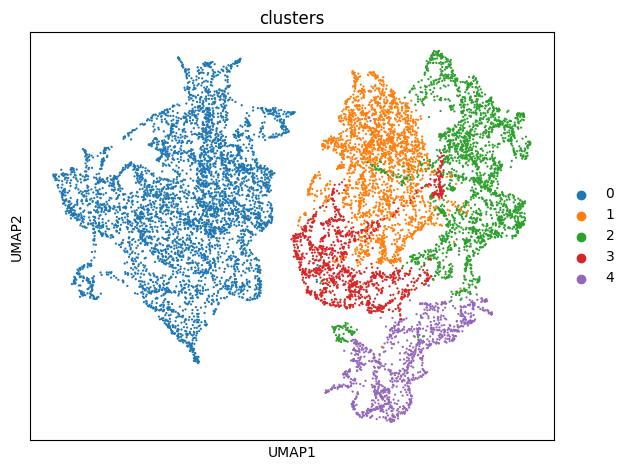

In [10]:
adata = clustering(adata, alpha=0, adata_save_path=results_save_path, cluster_resolution=0.1, 
                   plot_all_cluster_results=True, figsize=figsize, plot_x=plot_x, plot_y=plot_y)